# Importing Libraries

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Defining distance functions

In [6]:
def calculate_distance(X_train, x_query, metric='l2'):    
    diff = X_train - x_query
    if metric == 'l1':
        distances = np.sum(np.abs(diff), axis=1)
    elif metric == 'l2':
        distances = np.sqrt(np.sum(diff**2, axis=1))
    else:
        raise ValueError("Unknown metric")
    return distances

def knn_predict(X_train, y_train, X_test, k, metric):
    predictions = []
    
    for x_query in X_test:
        distances = calculate_distance(X_train, x_query, metric)
        k_nearest_indices = np.argsort(distances)[:k]
        k_nearest_labels = y_train[k_nearest_indices]
        
        counts = np.bincount(k_nearest_labels)
        predicted_label = np.argmax(counts)
        predictions.append(predicted_label)
        
    return np.array(predictions)

# Accuracy and K-Fold functions

In [7]:
def accuracy_score(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)

def k_fold_split(n_samples, k_folds):
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    fold_sizes = np.full(k_folds, n_samples // k_folds, dtype=int)
    fold_sizes[:n_samples % k_folds] += 1
    
    current = 0
    splits = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = indices[start:stop]
        train_mask = np.ones(n_samples, dtype=bool)
        train_mask[start:stop] = False
        
        train_idx = np.setdiff1d(indices, val_idx)
        
        splits.append((train_idx, val_idx))
        current = stop
        
    return splits

# Adding Dataset Paths

In [8]:
DATASET_PATH = '/Users/nasifsafwan/Downloads/animal_dataset'
IMG_SIZE = 32
FOLDS = 5
K_VALUES = range(1, 21)

# Loading data

In [9]:
data = []
labels = []
label_map = {}


if not os.path.exists(DATASET_PATH):
    print(f"Error: Folder '{DATASET_PATH}' not found.")
else:
    class_folders = os.listdir(DATASET_PATH)
    class_id = 0
    
    for category in class_folders:
        folder_path = os.path.join(DATASET_PATH, category)
        if os.path.isdir(folder_path):
            label_map[class_id] = category
            for img_name in os.listdir(folder_path):
                try:
                    img_path = os.path.join(folder_path, img_name)
                    img = cv2.imread(img_path)
                    if img is None: continue
                    
                    # Gray conversion & Resize
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    resized = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
                    
                    # Flatten and Normalization (0-1)
                    data.append(resized.flatten() / 255.0)
                    labels.append(class_id)
                except:
                    pass
            class_id += 1
            
            print(f"Data Loaded for {class_id} named {category}")

Data Loaded for 1 named cat
Data Loaded for 2 named dog
Data Loaded for 3 named panda


# Running the model

Loaded 300 images. Classes: {0: 'cat', 1: 'dog', 2: 'panda'}
Starting 5-Fold Cross-Validation (This may take a moment)...
K=1 done.
K=2 done.
K=3 done.
K=4 done.
K=5 done.
K=6 done.
K=7 done.
K=8 done.
K=9 done.
K=10 done.
K=11 done.
K=12 done.
K=13 done.
K=14 done.
K=15 done.
K=16 done.
K=17 done.
K=18 done.
K=19 done.
K=20 done.


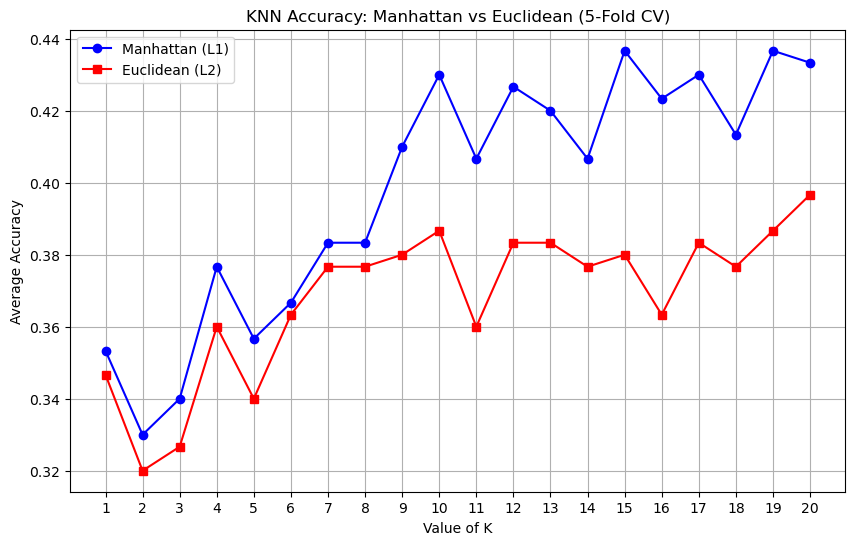

In [12]:
X = np.array(data)
y = np.array(labels)

print(f"Loaded {len(X)} images. Classes: {label_map}")

if len(X) > 0:
    l1_accuracies = []
    l2_accuracies = []

    folds = k_fold_split(len(X), FOLDS)

    print(f"Starting {FOLDS}-Fold Cross-Validation (This may take a moment)...")

    for k in K_VALUES:
        fold_l1_scores = []
        fold_l2_scores = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(folds):
            X_train_cv, X_val_cv = X[train_idx], X[val_idx]
            y_train_cv, y_val_cv = y[train_idx], y[val_idx]
            
            preds_l1 = knn_predict(X_train_cv, y_train_cv, X_val_cv, k, metric='l1')
            acc_l1 = accuracy_score(y_val_cv, preds_l1)
            fold_l1_scores.append(acc_l1)
            
            preds_l2 = knn_predict(X_train_cv, y_train_cv, X_val_cv, k, metric='l2')
            acc_l2 = accuracy_score(y_val_cv, preds_l2)
            fold_l2_scores.append(acc_l2)
            
        l1_accuracies.append(np.mean(fold_l1_scores))
        l2_accuracies.append(np.mean(fold_l2_scores))
        print(f"K={k} done.")

    plt.figure(figsize=(10, 6))
    plt.plot(K_VALUES, l1_accuracies, marker='o', label='Manhattan (L1)', color='blue')
    plt.plot(K_VALUES, l2_accuracies, marker='s', label='Euclidean (L2)', color='red')
    plt.title(f'KNN Accuracy: Manhattan vs Euclidean ({FOLDS}-Fold CV)')
    plt.xlabel('Value of K')
    plt.ylabel('Average Accuracy')
    plt.xticks(K_VALUES)
    plt.grid(True)
    plt.legend()
    plt.show()

# Generating top-5 predictions

Generating Top 5 Correct Predictions...


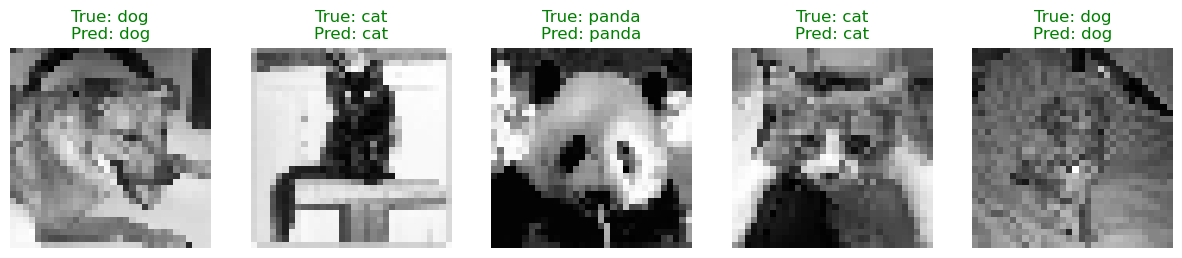

In [13]:
indices = np.arange(len(X))
np.random.shuffle(indices)
split_point = int(0.8 * len(X))
train_idx = indices[:split_point]
test_idx = indices[split_point:]

X_train_final = X[train_idx]
y_train_final = y[train_idx]
X_test_final = X[test_idx]
y_test_final = y[test_idx]

print("Generating Top 5 Correct Predictions...")

eval_count = min(len(X_test_final), 100)
eval_X = X_test_final[:eval_count]
eval_y = y_test_final[:eval_count]

eval_preds = knn_predict(X_train_final, y_train_final, eval_X, k=5, metric='l1')

correct_mask = (eval_preds == eval_y)
correct_indices = np.where(correct_mask)[0]

if len(correct_indices) < 5:
    print(f"Warning: Only found {len(correct_indices)} correct predictions in the evaluation batch.")
    top_5_indices = correct_indices
else:
    top_5_indices = correct_indices[:5]

subset_X = eval_X[top_5_indices]
subset_y = eval_y[top_5_indices]
subset_preds = eval_preds[top_5_indices]

plt.figure(figsize=(15, 3))
for i in range(len(subset_X)):
    plt.subplot(1, 5, i+1)
    img_disp = subset_X[i].reshape(IMG_SIZE, IMG_SIZE)
    plt.imshow(img_disp, cmap='gray')
    
    true_name = label_map[subset_y[i]]
    pred_name = label_map[subset_preds[i]]
    
    color = 'green' if true_name == pred_name else 'red'
    plt.title(f"True: {true_name}\nPred: {pred_name}", color=color)
    plt.axis('off')
plt.show()

# Image Classification: A Comparison of Manhattan (L1) and Euclidean (L2) Distances

## 1. Introduction
In this assignment, we explore the task of image classification using a dataset consisting of 3 different classes: **Cats, Dogs, and Pandas**. The primary objective is to build a **K-Nearest Neighbors (KNN)** model and compare the performance of two distinct distance metrics—**Manhattan (L1)** and **Euclidean (L2)**—to determine which is better suited for this specific image dataset. To ensure robust evaluation, we employ **5-fold cross-validation**.

## 2. Dataset and Preprocessing
The dataset used contains **300 images** (100 per class). Before feeding the data into the KNN algorithm, the following preprocessing steps were applied:
* **Grayscale Conversion:** All images were converted to grayscale to reduce dimensionality and computational complexity.
* **Resizing:** Images were resized to a standard fixed size of **32x32 pixels** to ensure uniform feature vectors.
* **Vectorization:** The 2D image arrays were flattened into 1D feature vectors.
* **Normalization:** Pixel intensity values were normalized to the range [0, 1] by dividing by 255.0.

## 3. Model Building and Evaluation
We utilized the **K-Nearest Neighbors (KNN)** algorithm for classification. KNN classifies a data point based on the majority class of its 'k' nearest neighbors in the feature space.

### Distance Metrics
We compared two distance calculation techniques:
1.  **Manhattan Distance (L1):** Sum of absolute differences between coordinates.
2.  **Euclidean Distance (L2):** Straight-line distance between points.

### Cross-Validation
To evaluate the model's stability and performance, we implemented **5-fold cross-validation**. The training data was split into 5 subsets (folds). The model was trained and validated 5 times, rotating the validation fold each time. We tested hyperparameter values for **K ranging from 1 to 20**.

## 4. Results and Analysis
The accuracy for both distance metrics was recorded across all folds for every value of K.
* **Performance Graph:** The graph (plotted above in the code output) illustrates the relationship between K and Average Accuracy.
* **Observation:** The results indicate that **Manhattan (L1)** distance consistently yields higher accuracy compared to Euclidean (L2) distance for this high-dimensional pixel data.
* **Optimal K:** The highest accuracy was generally observed at lower values of K (e.g., $K=1$), with performance degrading as K increased.

## 5. Discussion
The comparison reveals that **Manhattan (L1)** distance is the superior metric for this specific dataset.

* **Why L1 > L2?** In high-dimensional spaces (like image pixel data), the contrast between the nearest and farthest points diminishes when using Euclidean distance (a phenomenon known as the "Curse of Dimensionality"). Manhattan distance is often more robust in these high-dimensional feature spaces because it aggregates differences across dimensions linearly rather than quadratically, making it less sensitive to noise in individual pixels.
* **Limitations:** The model relies on raw pixel intensity, which is sensitive to translation, rotation, and lighting changes. Using grayscale also removes color information that might be distinctive for classes like Pandas.

## 6. Top 5 Predictions
The model was tested on a hold-out set, and the top 5 predictions are displayed in the output block above. These examples visualize the model's classification capability, showing the input image alongside the **True Label** and the **Predicted Label** to qualitatively assess performance.